<a href="https://colab.research.google.com/github/raniamaamer/spam-email-detection/blob/master/spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dataset_path = "/content/drive/MyDrive/spam_ham_dataset.csv"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Chargement et exploration des données
dataset = pd.read_csv(dataset_path)
dataset.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


In [ ]:
dataset.isnull().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [ ]:
dataset.shape

(5171, 4)

In [ ]:
dataset['label'].value_counts()

,count
label,
ham,3672
spam,1499


<ipython-input-17-611a625b676f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataset["label"].value_counts().index, y=dataset["label"].value_counts().values, palette="viridis")


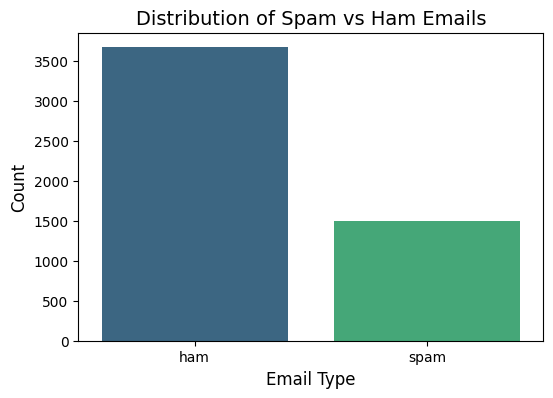

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=dataset["label"].value_counts().index, y=dataset["label"].value_counts().values, palette="viridis")

plt.title("Distribution of Spam vs Ham Emails", fontsize=14)
plt.xlabel("Email Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

In [ ]:
dataset['label'].value_counts(normalize=True) * 100

,proportion
label,
ham,71.01141
spam,28.98859


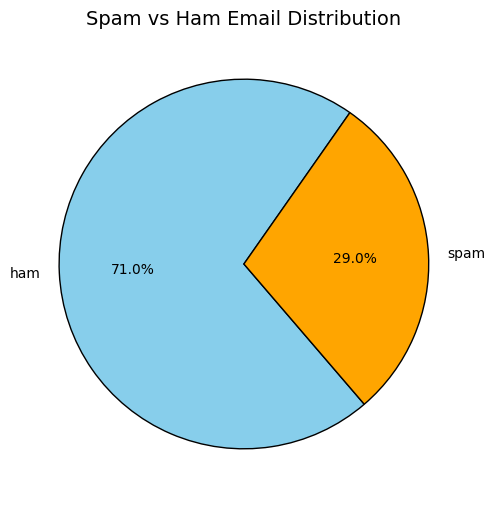

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(dataset["label"].value_counts(normalize=True).values*100, labels=dataset["label"].value_counts().index,
        autopct='%1.1f%%', colors=["skyblue", "orange"], startangle=55, wedgeprops={'edgecolor': 'black'})

plt.title("Spam vs Ham Email Distribution", fontsize=14)

plt.show()

In [ ]:
dataset.isna().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [ ]:
dataset.duplicated().sum()

np.int64(0)

In [ ]:
df = dataset[['text','label_num']]
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
length = len(df['text'])

In [ ]:
corpus=[]
# contain list of words that will be used for training -> final words after cleaning

for i in range(0,length):
  # re is used to remove punctuations
  text = re.sub('[^a-zA-Z]',' ',df['text'][i]) # replaces the punctuation with space

  # converting to lowercase
  text=text.lower()

  # stemming
  text=text.split()
  ps = PorterStemmer()
  all_stopwords=stopwords.words('english')
  text = [ps.stem(word) for word  in text if not word in set(all_stopwords)]
  text = ' '.join(text)

  corpus.append(text)

In [ ]:
corpus[0:5]

['subject enron methanol meter follow note gave monday preliminari flow data provid daren pleas overrid pop daili volum present zero reflect daili activ obtain ga control chang need asap econom purpos',
 'subject hpl nom januari see attach file hplnol xl hplnol xl',
 'subject neon retreat ho ho ho around wonder time year neon leader retreat time know time year extrem hectic tough think anyth past holiday life go past week decemb januari like think minut calend hand begin fall semest retreat schedul weekend januari youth minist confer brad dustin connect week go chang date follow weekend januari come part need think think agre import us get togeth time recharg batteri get far spring semest lot troubl difficult us get away without kid etc brad came potenti altern get togeth weekend let know prefer first option would retreat similar done past sever year year could go heartland countri inn www com outsid brenham nice place bedroom bedroom hous side side countri real relax also close brenha

In [ ]:
df = df.copy()

In [ ]:
df['cleanText'] = corpus

In [ ]:
df

,text,label_num,cleanText
0,Subject: enron methanol ; meter # : 988291\r\n...,0,subject enron methanol meter follow note gave ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,subject hpl nom januari see attach file hplnol...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,subject neon retreat ho ho ho around wonder ti...
3,"Subject: photoshop , windows , office . cheap ...",1,subject photoshop window offic cheap main tren...
4,Subject: re : indian springs\r\nthis deal is t...,0,subject indian spring deal book teco pvr reven...
...,...,...,...
5166,Subject: put the 10 on the ft\r\nthe transport...,0,subject put ft transport volum decreas contrac...
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,subject follow nom hpl take extra mmcf weekend...
5168,Subject: calpine daily gas nomination\r\n>\r\n...,0,subject calpin daili ga nomin juli mention ear...
5169,Subject: industrial worksheets for august 2000...,0,subject industri worksheet august activ attach...


In [ ]:
df['cleanText']=df['cleanText'].str.replace('subject', '')

In [ ]:
df

,text,label_num,cleanText
0,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter follow note gave monday ...
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom januari see attach file hplnol xl hpl...
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat ho ho ho around wonder time year...
3,"Subject: photoshop , windows , office . cheap ...",1,photoshop window offic cheap main trend abas ...
4,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenu under...
...,...,...,...
5166,Subject: put the 10 on the ft\r\nthe transport...,0,put ft transport volum decreas contract thank...
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0,follow nom hpl take extra mmcf weekend tri ne...
5168,Subject: calpine daily gas nomination\r\n>\r\n...,0,calpin daili ga nomin juli mention earlier ho...
5169,Subject: industrial worksheets for august 2000...,0,industri worksheet august activ attach worksh...


In [ ]:
x=df.loc[:,'cleanText'].values
y=df.loc[:,'label_num'].values

In [ ]:

vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(dataset['text'])  # Transformer le texte en valeurs numériques

# Définir la variable cible
y = dataset['label']  # Remplace 'label' par le vrai nom de ta colonne cible

# Séparer les données en train/test
x_train, x_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Vérification après transformation
print(type(x_train))  # Doit afficher <class 'scipy.sparse._csr.csr_matrix'>

<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
x

array([' enron methanol meter follow note gave monday preliminari flow data provid daren pleas overrid pop daili volum present zero reflect daili activ obtain ga control chang need asap econom purpos',
       ' hpl nom januari see attach file hplnol xl hplnol xl',
       ' neon retreat ho ho ho around wonder time year neon leader retreat time know time year extrem hectic tough think anyth past holiday life go past week decemb januari like think minut calend hand begin fall semest retreat schedul weekend januari youth minist confer brad dustin connect week go chang date follow weekend januari come part need think think agre import us get togeth time recharg batteri get far spring semest lot troubl difficult us get away without kid etc brad came potenti altern get togeth weekend let know prefer first option would retreat similar done past sever year year could go heartland countri inn www com outsid brenham nice place bedroom bedroom hous side side countri real relax also close brenham o

In [ ]:
x[453]

' dave n pocket next week beyond class next week hyatt unifi perform issu need immedi attent pleas call jim ogg kishor b russ whitton alreadi pager number also next month offic space gut built locat allen center th floor conveni phone number feel free send postcard n'

In [ ]:
y

,label
0,ham
1,ham
2,ham
3,spam
4,ham
...,...
5166,ham
5167,ham
5168,ham
5169,ham


In [ ]:
# Entraînement des différents modèles

# Decision Tree
dt_best = DecisionTreeClassifier(random_state=42)
dt_best.fit(x_train, y_train)

# Random Forest
rf_best = RandomForestClassifier(n_estimators=100, random_state=42)
rf_best.fit(x_train, y_train)

# KNN
knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(x_train, y_train)

# Naive Bayes
nb_best = MultinomialNB()
nb_best.fit(x_train, y_train)

# Gradient Boosting
gb_best = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_best.fit(x_train, y_train)

# AdaBoost
ada_best = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_best.fit(x_train, y_train)


AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
def train_test_model(model):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    score=accuracy_score(y_test,y_pred)
    print(f'accuracy score of {model} is :{score}')
    print(f'{classification_report(y_test,y_pred)}')
    mx=confusion_matrix(y_test,y_pred)
    sns.heatmap(mx,annot=True, fmt='d', cmap='Blues', xticklabels=['Not spam', 'spam'], yticklabels=['Not spam', 'spam'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
# Modèle de stacking plus rapide
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500)),
        ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('nb', MultinomialNB())
    ],
    final_estimator=LogisticRegression(max_iter=500)  # plus rapide que RandomForest
)

# Modèles
models = {
    "Régression Logistique": LogisticRegression(max_iter=500),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "Stacking Classifier": stacking_model
}

accuracy score of LogisticRegression() is :0.9826086956521739
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       742
        spam       0.96      0.98      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



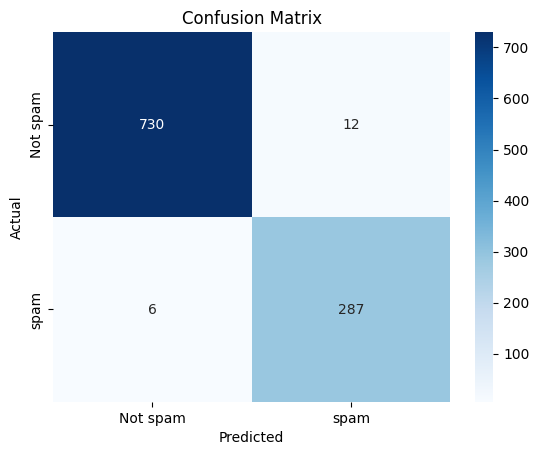

In [ ]:
train_test_model(LogisticRegression())

accuracy score of DecisionTreeClassifier(max_depth=20) is :0.9429951690821256
              precision    recall  f1-score   support

         ham       0.97      0.95      0.96       742
        spam       0.88      0.93      0.90       293

    accuracy                           0.94      1035
   macro avg       0.92      0.94      0.93      1035
weighted avg       0.94      0.94      0.94      1035



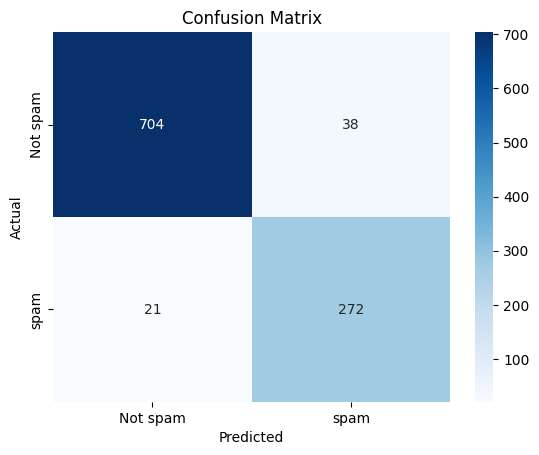

In [ ]:
train_test_model(DecisionTreeClassifier(max_depth=20))

accuracy score of RandomForestClassifier() is :0.978743961352657
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       742
        spam       0.97      0.95      0.96       293

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



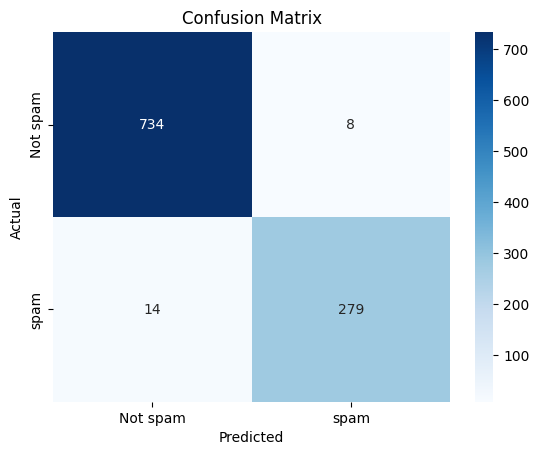

In [ ]:
train_test_model(RandomForestClassifier())

accuracy score of KNeighborsClassifier(n_neighbors=2) is :0.927536231884058
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       742
        spam       1.00      0.75      0.85       293

    accuracy                           0.93      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.93      0.92      1035



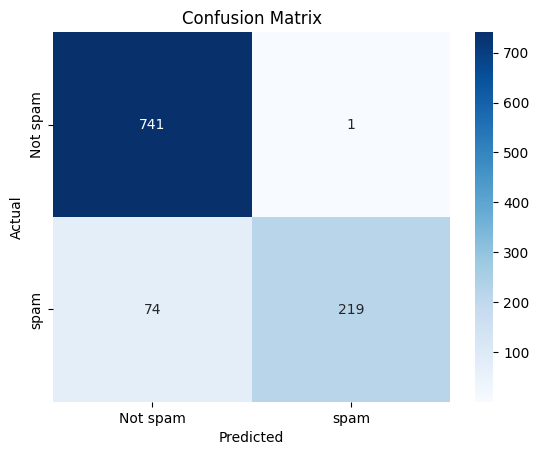

In [ ]:
train_test_model(KNeighborsClassifier(n_neighbors=2))

accuracy score of MultinomialNB() is :0.8782608695652174
              precision    recall  f1-score   support

         ham       0.85      1.00      0.92       742
        spam       1.00      0.57      0.73       293

    accuracy                           0.88      1035
   macro avg       0.93      0.78      0.82      1035
weighted avg       0.90      0.88      0.87      1035



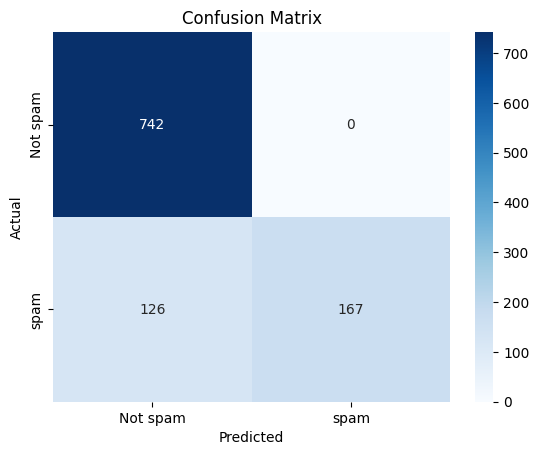

In [ ]:
train_test_model(MultinomialNB())

accuracy score of GradientBoostingClassifier() is :0.9690821256038648
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       742
        spam       0.94      0.95      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



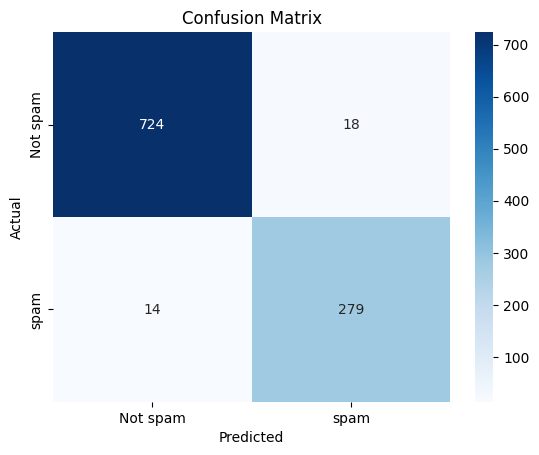

In [ ]:
train_test_model(GradientBoostingClassifier())

accuracy score of AdaBoostClassifier() is :0.9217391304347826
              precision    recall  f1-score   support

         ham       0.94      0.95      0.95       742
        spam       0.86      0.86      0.86       293

    accuracy                           0.92      1035
   macro avg       0.90      0.90      0.90      1035
weighted avg       0.92      0.92      0.92      1035



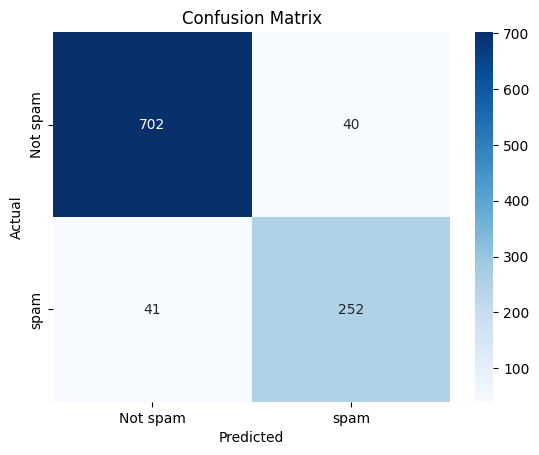

In [ ]:
train_test_model(AdaBoostClassifier())

accuracy score of StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                               ('knn', KNeighborsClassifier()),
                               ('nb', MultinomialNB())],
                   final_estimator=LogisticRegression(max_iter=500)) is :0.9884057971014493
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       742
        spam       0.98      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.98      0.99      1035
weighted avg       0.99      0.99      0.99      1035



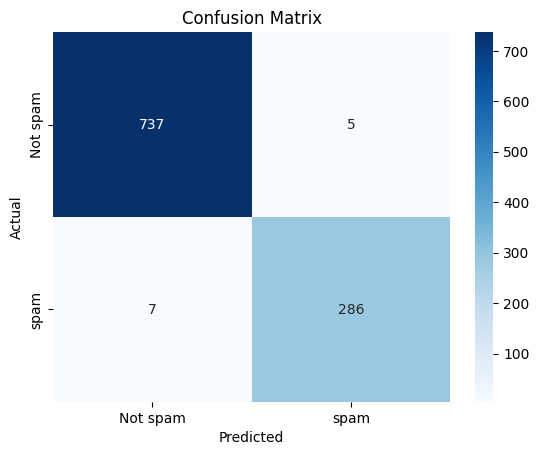

In [ ]:
train_test_model(stacking_model)

In [ ]:
param_grid_dt = {'max_depth': [10, 20, 30], 'criterion': ['gini', 'entropy']}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

param_grid_stacking = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs']
}


estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=10))
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

stacking_grid = GridSearchCV(
    stacking,
    param_grid_stacking,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [ ]:
dt_grid.fit(x_train, y_train)
rf_grid.fit(x_train, y_train)
knn_grid.fit(x_train, y_train)
stacking_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('rf',
                                                       RandomForestClassifier()),
                                                      ('knn',
                                                       KNeighborsClassifier()),
                                                      ('dt',
                                                       DecisionTreeClassifier(max_depth=10))],
                                          final_estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.1, 1.0, 10.0],
                         'final_estimator__penalty': ['l2'],
                         'final_estimator__solver': ['lbfgs']},
             scoring='accuracy')

In [ ]:
print("Best Decision Tree params:", dt_grid.best_params_, "Score:", dt_grid.best_score_)
print("Best Random Forest params:", rf_grid.best_params_, "Score:", rf_grid.best_score_)
print("Best KNN params:", knn_grid.best_params_, "Score:", knn_grid.best_score_)

dt_best = dt_grid.best_estimator_
rf_best = rf_grid.best_estimator_
knn_best = knn_grid.best_estimator_
stacking_best = stacking_grid.best_estimator_

print("Decision Tree Test Accuracy:", dt_best.score(x_test, y_test))
print("Random Forest Test Accuracy:", rf_best.score(x_test, y_test))
print("KNN Test Accuracy:", knn_best.score(x_test, y_test))
print("Stacking Classifier Test Accuracy:",knn_best.score(x_test, y_test))

Best Decision Tree params: {'criterion': 'gini', 'max_depth': 20} Score: 0.9395542353772731
Best Random Forest params: {'max_depth': 30, 'n_estimators': 100} Score: 0.9458426067095432
Best KNN params: {'n_neighbors': 3, 'weights': 'distance'} Score: 0.9608310113383454
Decision Tree Test Accuracy: 0.9497584541062802
Random Forest Test Accuracy: 0.9536231884057971
KNN Test Accuracy: 0.9507246376811594
Stacking Classifier Test Accuracy: 0.9507246376811594


In [ ]:
results = {
    "Modèle": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    results["Modèle"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred, pos_label='spam'))
    results["Recall"].append(recall_score(y_test, y_pred, pos_label='spam'))
    results["F1 Score"].append(f1_score(y_test, y_pred, pos_label='spam'))

    print(f"----- {name} -----")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision :", precision_score(y_test, y_pred, pos_label='spam'))
    print("Recall :", recall_score(y_test, y_pred, pos_label='spam'))
    print("F1 Score :", f1_score(y_test, y_pred, pos_label='spam'))
    print()


----- Régression Logistique -----
Accuracy : 0.9826086956521739
Precision : 0.959866220735786
Recall : 0.9795221843003413
F1 Score : 0.9695945945945946

----- K-Nearest Neighbors (KNN) -----
Accuracy : 0.9468599033816425
Precision : 0.9722222222222222
Recall : 0.8361774744027304
F1 Score : 0.8990825688073395

----- Naive Bayes -----
Accuracy : 0.8782608695652174
Precision : 1.0
Recall : 0.5699658703071673
F1 Score : 0.7260869565217392

----- Random Forest -----
Accuracy : 0.7855072463768116
Precision : 1.0
Recall : 0.24232081911262798
F1 Score : 0.3901098901098901

----- Gradient Boosting -----
Accuracy : 0.9710144927536232
Precision : 0.9311475409836065
Recall : 0.9692832764505119
F1 Score : 0.9498327759197325

----- AdaBoost -----
Accuracy : 0.9217391304347826
Precision : 0.863013698630137
Recall : 0.8600682593856656
F1 Score : 0.8615384615384616

----- Stacking Classifier -----
Accuracy : 0.9884057971014493
Precision : 0.9828178694158075
Recall : 0.9761092150170648
F1 Score : 0.9794

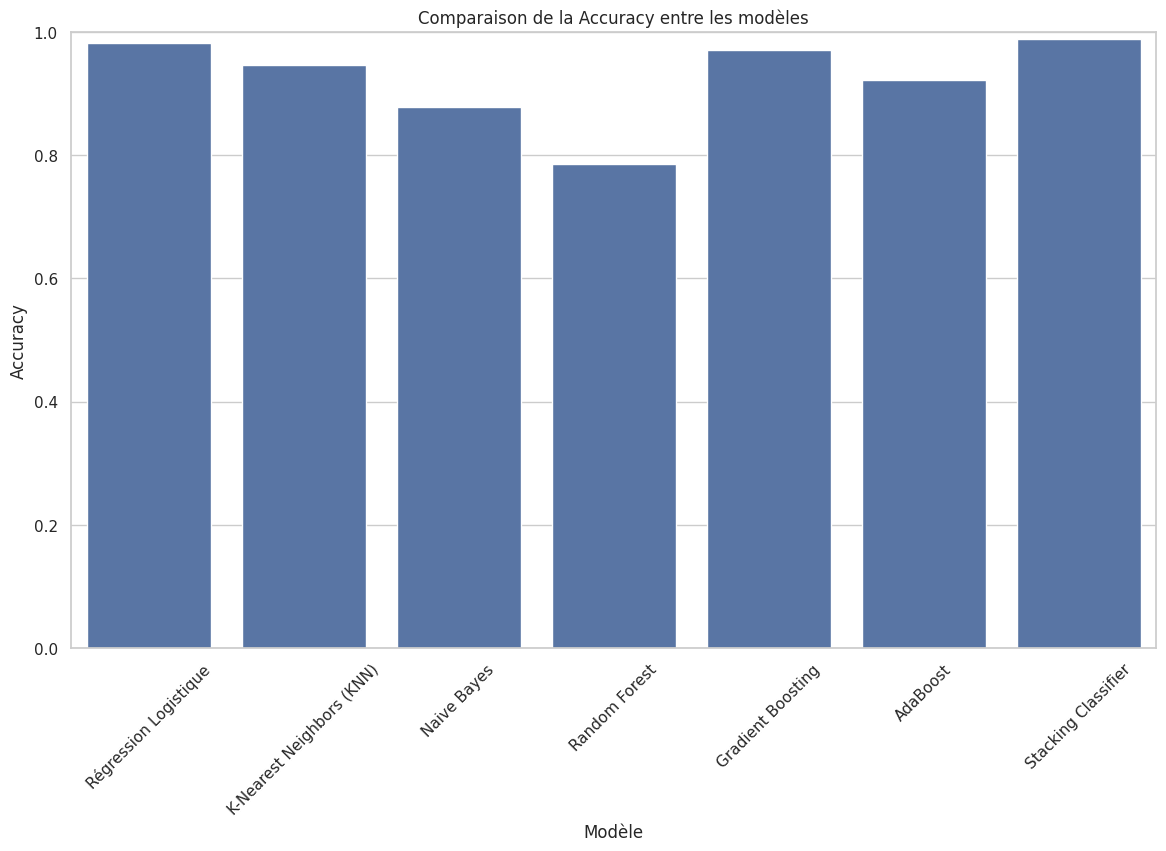

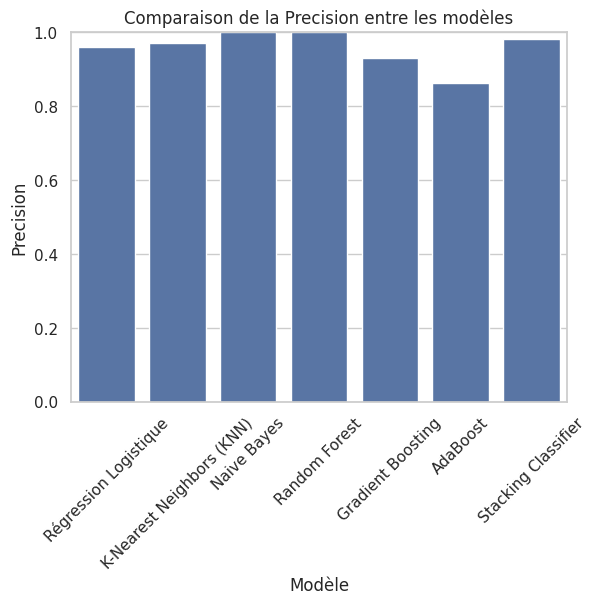

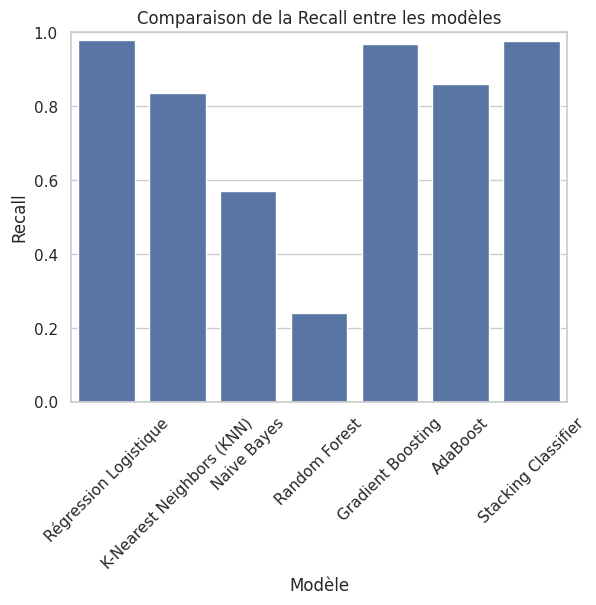

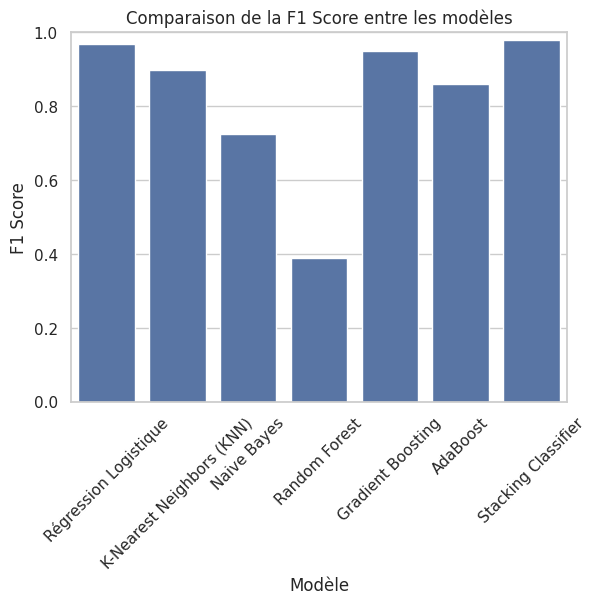

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
for metric in metrics:
    sns.barplot(x="Modèle", y=metric, data=pd.DataFrame(results))
    plt.title(f"Comparaison de la {metric} entre les modèles")
    plt.ylabel(metric)
    plt.xlabel("Modèle")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

In [ ]:
results = {
    "Modèle": ["Decision Tree", "Random Forest", "KNN", "Naive Bayes", "Gradient Boosting", "AdaBoost", "Stacking"],
    "Test Accuracy": [
        dt_best.score(x_test, y_test),
        rf_best.score(x_test, y_test),
        knn_best.score(x_test, y_test),
        nb_best.score(x_test, y_test),
        gb_best.score(x_test, y_test),
        ada_best.score(x_test, y_test),
        stacking_best.score(x_test, y_test)
    ]
}

ranked = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False)

print("📈 Classement des modèles selon la Test Accuracy :")
print(ranked[["Modèle", "Test Accuracy"]])


📈 Classement des modèles selon la Test Accuracy :
              Modèle  Test Accuracy
6           Stacking       0.988406
4  Gradient Boosting       0.972947
1      Random Forest       0.953623
2                KNN       0.950725
0      Decision Tree       0.949758
5           AdaBoost       0.949758
3        Naive Bayes       0.878261
